In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch.utils.data import DataLoader
from dataset import make_dataset

train_set, eval_set = make_dataset('E:\\zbf\\zbf-train-realMix', pairs=10000)
image_datasets = {
    'train':train_set, 'eval':eval_set
}

batch_size = 20

dataloaders = {
    'train':DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory = True),
    'eval':DataLoader(eval_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory = True)
}

dataset_sizes = {
    x:len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 10000, 'eval': 2000}

In [4]:
from collections import defaultdict
import lossfunc
import indice
import time  

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
            if phase == 'train':  
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0
            epoch_loss = 0
            
            for sources, templates, bsimilars in dataloaders[phase]:
                sources = sources.to(device)
                templates = templates.to(device)             
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    out_srcs, out_tpts = model(sources, templates)
                    
                    # switch NCC or SSIM
                    nccs = indice.batch_ncc(out_srcs, out_tpts)
                    # nccs = indice.batch_ssim_silly(out_srcs, out_tpts)
                    
                    nccs = nccs.to(device)
                    bsimilars = bsimilars.to(device)
                    loss = lossfunc.loss(nccs, bsimilars, device=device)
                   
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += sources.size(0)
                epoch_loss += loss.detach().cpu().numpy() * sources.size(0)
                
            epoch_loss /= epoch_samples
            print('loss: {:4f}'.format(epoch_loss))
            
            if phase == 'train':
                scheduler.step()
                
            elif phase == 'eval' and epoch_loss < best_loss:
                # deep copy the model
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
import torch
import nccnet
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = nccnet.NCCNet().to(device)
model.apply(nccnet.weights_init)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=25)

cuda:0
Epoch 0/24
----------
LR 0.0001
loss: -0.187567
loss: -0.372000
saving best model
93m 13s
Epoch 1/24
----------
LR 0.0001
loss: -0.229207
loss: -0.403116
saving best model
91m 46s
Epoch 2/24
----------
LR 0.0001
loss: -0.248999
loss: -0.431035
saving best model
91m 51s
Epoch 3/24
----------
LR 0.0001
loss: -0.268802
loss: -0.460639
saving best model
91m 49s
Epoch 4/24
----------
LR 0.0001
loss: -0.280475
loss: -0.476575
saving best model
91m 48s
Epoch 5/24
----------
LR 0.0001
loss: -0.290100
loss: -0.490990
saving best model
91m 49s
Epoch 6/24
----------
LR 0.0001
loss: -0.298477
loss: -0.502011
saving best model
92m 0s
Epoch 7/24
----------
LR 0.0001
loss: -0.304411
loss: -0.510639
saving best model
92m 15s
Epoch 8/24
----------
LR 0.0001
loss: -0.306517
loss: -0.518560
saving best model
91m 51s
Epoch 9/24
----------
LR 0.0001
loss: -0.312800
loss: -0.522450
saving best model
91m 45s
Epoch 10/24
----------
LR 1e-05
loss: -0.318001
loss: -0.528262
saving best model
91m 54s
Epoc

In [6]:
import os
save_path = 'D:\\cbh_workspace\\OtherCode\\python\\NCCNet-torch'
filename = 'NCCNet-real.pth.tar'
torch.save(model.state_dict(), os.path.join(save_path, filename))

In [7]:
import torch
import nccnet
from NCC import batch_ncc
from dataset import default_loader
import os
import matplotlib.pyplot as plt
import helper

def load_model(filepath='D:\\cbh_workspace\\OtherCode\\python\\NCCNet-torch', filename='NCCNet-real.pth.tar'):
    model = nccnet.NCCNet()
    model.load_state_dict(torch.load(os.path.join(filepath, filename)))
    model.eval()
    return model


In [20]:

dir = 'E:\\zbf\\zbf-test2'

model = load_model()
for i in range(1):
    i = 2
    source_name = '{:0>8d}_s.tif'.format(i)
    template_name = '{:0>8d}_t.tif'.format(i)
    print(source_name)
    source_img = default_loader(os.path.join(dir, source_name))
    template_img = default_loader(os.path.join(dir, template_name))
    source_img = torch.unsqueeze(source_img, 0)
    template_img = torch.unsqueeze(template_img, 0)
    
    ncc_pre = batch_ncc(source_img, template_img)
    
    source_f, template_f = model(source_img, template_img)
    print(source_f, type(source_f), source_f.shape)
    
    source_f = source_f.cpu().detach()
    template_f = template_f.cpu().detach()
    
    ncc = batch_ncc(source_f, template_f)
    

00000002_s.tif
tensor([[[[ 0.2817, -0.3064,  0.1104,  ...,  0.2347,  0.4655,  0.1809],
          [-0.0206,  0.0850, -0.2607,  ..., -0.2662, -0.3175,  0.2769],
          [-0.3809, -0.4793, -0.2767,  ..., -0.9818, -0.8022, -0.0313],
          ...,
          [ 0.0191, -0.2522, -0.0091,  ...,  0.3096,  0.4797, -0.0228],
          [-0.2441,  0.0725, -0.2312,  ...,  0.1934,  0.2186,  0.0357],
          [-0.3418, -0.2133,  0.0292,  ...,  0.0923,  0.2944,  0.2387]]]],
       grad_fn=<NativeBatchNormBackward>) <class 'torch.Tensor'> torch.Size([1, 1, 512, 512])


In [21]:
ncc_pre = ncc_pre.squeeze().numpy()
ncc = ncc.squeeze().numpy()
source_f = source_f.squeeze().numpy()
template_f = template_f.squeeze().numpy()
    

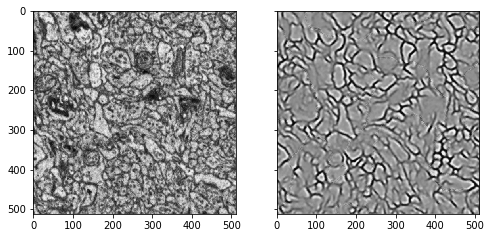

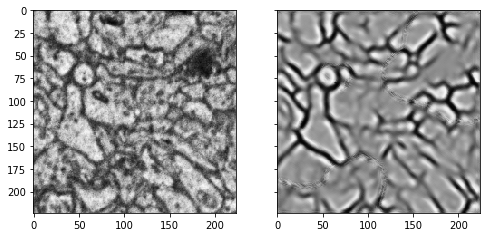

In [22]:
import helper
source_img_n = source_img.squeeze().numpy()
template_img_n = template_img.squeeze().numpy()
helper.plot_img_array([source_img_n, source_f], ncol=2)
helper.plot_img_array([template_img_n, template_f], ncol=2)

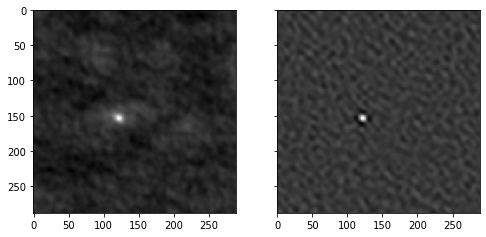

In [23]:
helper.plot_img_array([ncc_pre, ncc], ncol=2)

In [23]:
import numpy
print(numpy.unravel_index(ncc_pre.argmax(), ncc_pre.shape), numpy.max(source_f), numpy.min(source_f))
print(numpy.unravel_index(ncc.argmax(), ncc.shape), numpy.max(template_f), numpy.min(template_f))

(226, 115) 1.242538 -1.3294057
(226, 115) 1.2216446 -1.3120966


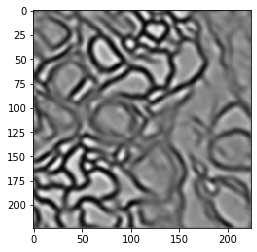

In [64]:
import matplotlib.pyplot as plt

plt.imshow(source_f, cmap='gray')
plt.savefig(os.path.join(save_path, 'source_img_n.tif'))
plt.imshow(template_f, cmap='gray')
plt.savefig(os.path.join(save_path, 'template_img_n.tif'))

# cv2.imwrite(os.path.join(save_path, 'source_f.tif'), source_f)
# cv2.imwrite(os.path.join(save_path, 'template_f.tif'), template_f)